https://dacon.io/competitions/open/235536/overview/description

데이터 분석 과 머신러닝을 처음 접하시는 분들  
혹은 데이콘 대회를 연습으로 경험해보고 싶으신 분들은 
해당 대회를 통해 영화 관객수를 예측해 보세요.

1. movies_train.csv / movies_test.csv
title : 영화의 제목
distributor : 배급사
genre : 장르
release_time : 개봉일
time : 상영시간(분)
screening_rat : 상영등급
director : 감독이름
dir_prev_bfnum : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화에서의 평균 관객수(단 관객수가 알려지지 않은 영화 제외)
dir_prev_num : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화의 개수(단 관객수가 알려지지 않은 영화 제외)
num_staff : 스텝수
num_actor : 주연배우수
box_off_num : 관객수


2.  submission.csv (제출 파일 형식)

데이터 상세 설명
2010년대 한국에서 개봉한 한국영화 600개에 대한 감독, 이름, 상영등급, 관객수 등의 정보가 담긴 데이터

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

from sklearn.preprocessing import LabelEncoder

if os.name == 'posix':
    plt.rc("font", family="AppleGothic")
else:
    plt.rc("font", family="Malgun Gothic")

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error, r2_score


In [2]:
path = './dataset/영화 관객수/'

In [3]:
df_train = pd.read_csv(path + 'movies_train.csv')
df_test = pd.read_csv(path + 'movies_test.csv')
df_submission = pd.read_csv(path + 'submission.csv')

In [4]:
df_train

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083
3,나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866
4,불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387
...,...,...,...,...,...,...,...,...,...,...,...,...
595,해무,(주)NEW,드라마,2014-08-13,111,청소년 관람불가,심성보,3833.00,1,510,7,1475091
596,파파로티,(주)쇼박스,드라마,2013-03-14,127,15세 관람가,윤종찬,496061.00,1,286,6,1716438
597,살인의 강,(주)마운틴픽쳐스,공포,2010-09-30,99,청소년 관람불가,김대현,NaN,0,123,4,2475
598,악의 연대기,CJ 엔터테인먼트,느와르,2015-05-14,102,15세 관람가,백운학,NaN,0,431,4,2192525


# 1. 전처리


### 전처리 방향
title은 제목이 겹치는지 1차 확인 -> train과 test에 title이 분명 겹치지 않을것 같은데 이 부분을 어떻게 처리해야하는게 합리적일까..

distributor, genre는 라벨링 처리를 해야하는데 갯수를 플랏해볼 필요 있음

director는 생각해봐야할 것이 동명이인일 경우 어떻게 해야할지 고민해야함

release_time 은 연도와 월만 신경써서 라벨링 해야할거 같음

### 1) Nan 데이터 처리

In [5]:
df_train.info(), df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           600 non-null    object 
 1   distributor     600 non-null    object 
 2   genre           600 non-null    object 
 3   release_time    600 non-null    object 
 4   time            600 non-null    int64  
 5   screening_rat   600 non-null    object 
 6   director        600 non-null    object 
 7   dir_prev_bfnum  270 non-null    float64
 8   dir_prev_num    600 non-null    int64  
 9   num_staff       600 non-null    int64  
 10  num_actor       600 non-null    int64  
 11  box_off_num     600 non-null    int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 56.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ti

(None, None)

In [6]:
df_train.describe()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
count,600.000000,2.700000e+02,600.000000,600.000000,600.000000,6.000000e+02
mean,100.863333,1.050443e+06,0.876667,151.118333,3.706667,7.081818e+05
std,18.097528,1.791408e+06,1.183409,165.654671,2.446889,1.828006e+06
min,45.000000,1.000000e+00,0.000000,0.000000,0.000000,1.000000e+00
25%,89.000000,2.038000e+04,0.000000,17.000000,2.000000,1.297250e+03
50%,100.000000,4.784236e+05,0.000000,82.500000,3.000000,1.259100e+04
75%,114.000000,1.286569e+06,2.000000,264.000000,4.000000,4.798868e+05
max,180.000000,1.761531e+07,5.000000,869.000000,25.000000,1.426277e+07


#### dir_prev_bfnum 삭제

In [7]:
df_train.drop(columns='dir_prev_bfnum', inplace=True)
df_test.drop(columns='dir_prev_bfnum', inplace=True)

In [8]:
df_train['distributor'].value_counts()

CJ 엔터테인먼트        54
롯데엔터테인먼트         52
(주)NEW           30
(주)마운틴픽쳐스        29
(주)쇼박스           26
                 ..
OAL(올)            1
(주)에이원 엔터테인먼트     1
(주)콘텐츠 윙          1
위더스필름             1
퍼스트런              1
Name: distributor, Length: 169, dtype: int64

#### train 데이터, test 데이터 각각 title 내에서 중복 확인

In [9]:
print([df_train.title[i]  for i in range(len(df_train)) if df_train.title.value_counts()[i] != 1])
print([df_test.title[i]  for i in range(len(df_test)) if df_test.title.value_counts()[i] != 1])

[]
[]


#### train 데이터와 test 데이터 title 중복 확인

In [10]:
set(df_train['title']) & set(df_test['title'])

set()

- 타이틀을 인덱스로 써도 학습이 될까??

In [11]:
# df_train.index = df_train['title']
# df_test.index = df_test['title']

df_train.drop(columns='title', inplace=True)
df_test.drop(columns='title', inplace=True)

#### 배급사에 따라 관객 수가 달라질까?

In [12]:
df_train_db = df_train.groupby('distributor').count()

In [13]:
# plt.bar(df_train_db['box_off_num'].sort_values().index, df_train_db['box_off_num'].sort_values())
# plt.xticks(rotation = 90)
# plt.show()
df_train_db['box_off_num'].sort_values()

distributor
마법사필름               1
와이드 릴리즈(주)          1
와이드릴리즈(주)           1
두 엔터테인먼트            1
동국대학교 충무로영상제작센터     1
                   ..
인디스토리              26
(주)마운틴픽쳐스          29
(주)NEW             30
롯데엔터테인먼트           52
CJ 엔터테인먼트          54
Name: box_off_num, Length: 169, dtype: int64

In [14]:
dist_name = list(df_train['distributor'].unique())
dist_avg = [df_train[ df_train['distributor'] == i]['box_off_num'].mean()  for i in dist_name]

# plt.bar(dist_name, dist_avg)
# plt.xticks(rotation = 90)
# plt.show()
df_train_db.loc['CJ 엔터테인먼트', :]['box_off_num']

54

In [15]:
df_train_db_avg = pd.DataFrame(dist_avg, index=dist_name)

df_train_db_avg = df_train_db_avg.rename(columns={0 : 'box_off_num_avg'})

df_train_db_avg['box_off_num'] = df_train_db['box_off_num']
df_train_db_avg

,box_off_num_avg,box_off_num
롯데엔터테인먼트,1.238149e+06,52
(주)쇼박스,3.386656e+06,26
(주)NEW,2.184405e+06,30
쇼박스(주)미디어플렉스,2.634823e+06,2
백두대간,2.728300e+04,2
...,...,...
영화사 廊,7.173000e+03,1
크리에이티브컴즈(주),1.880000e+02,1
ysfilm,1.720000e+02,1
이달투,3.556700e+04,1


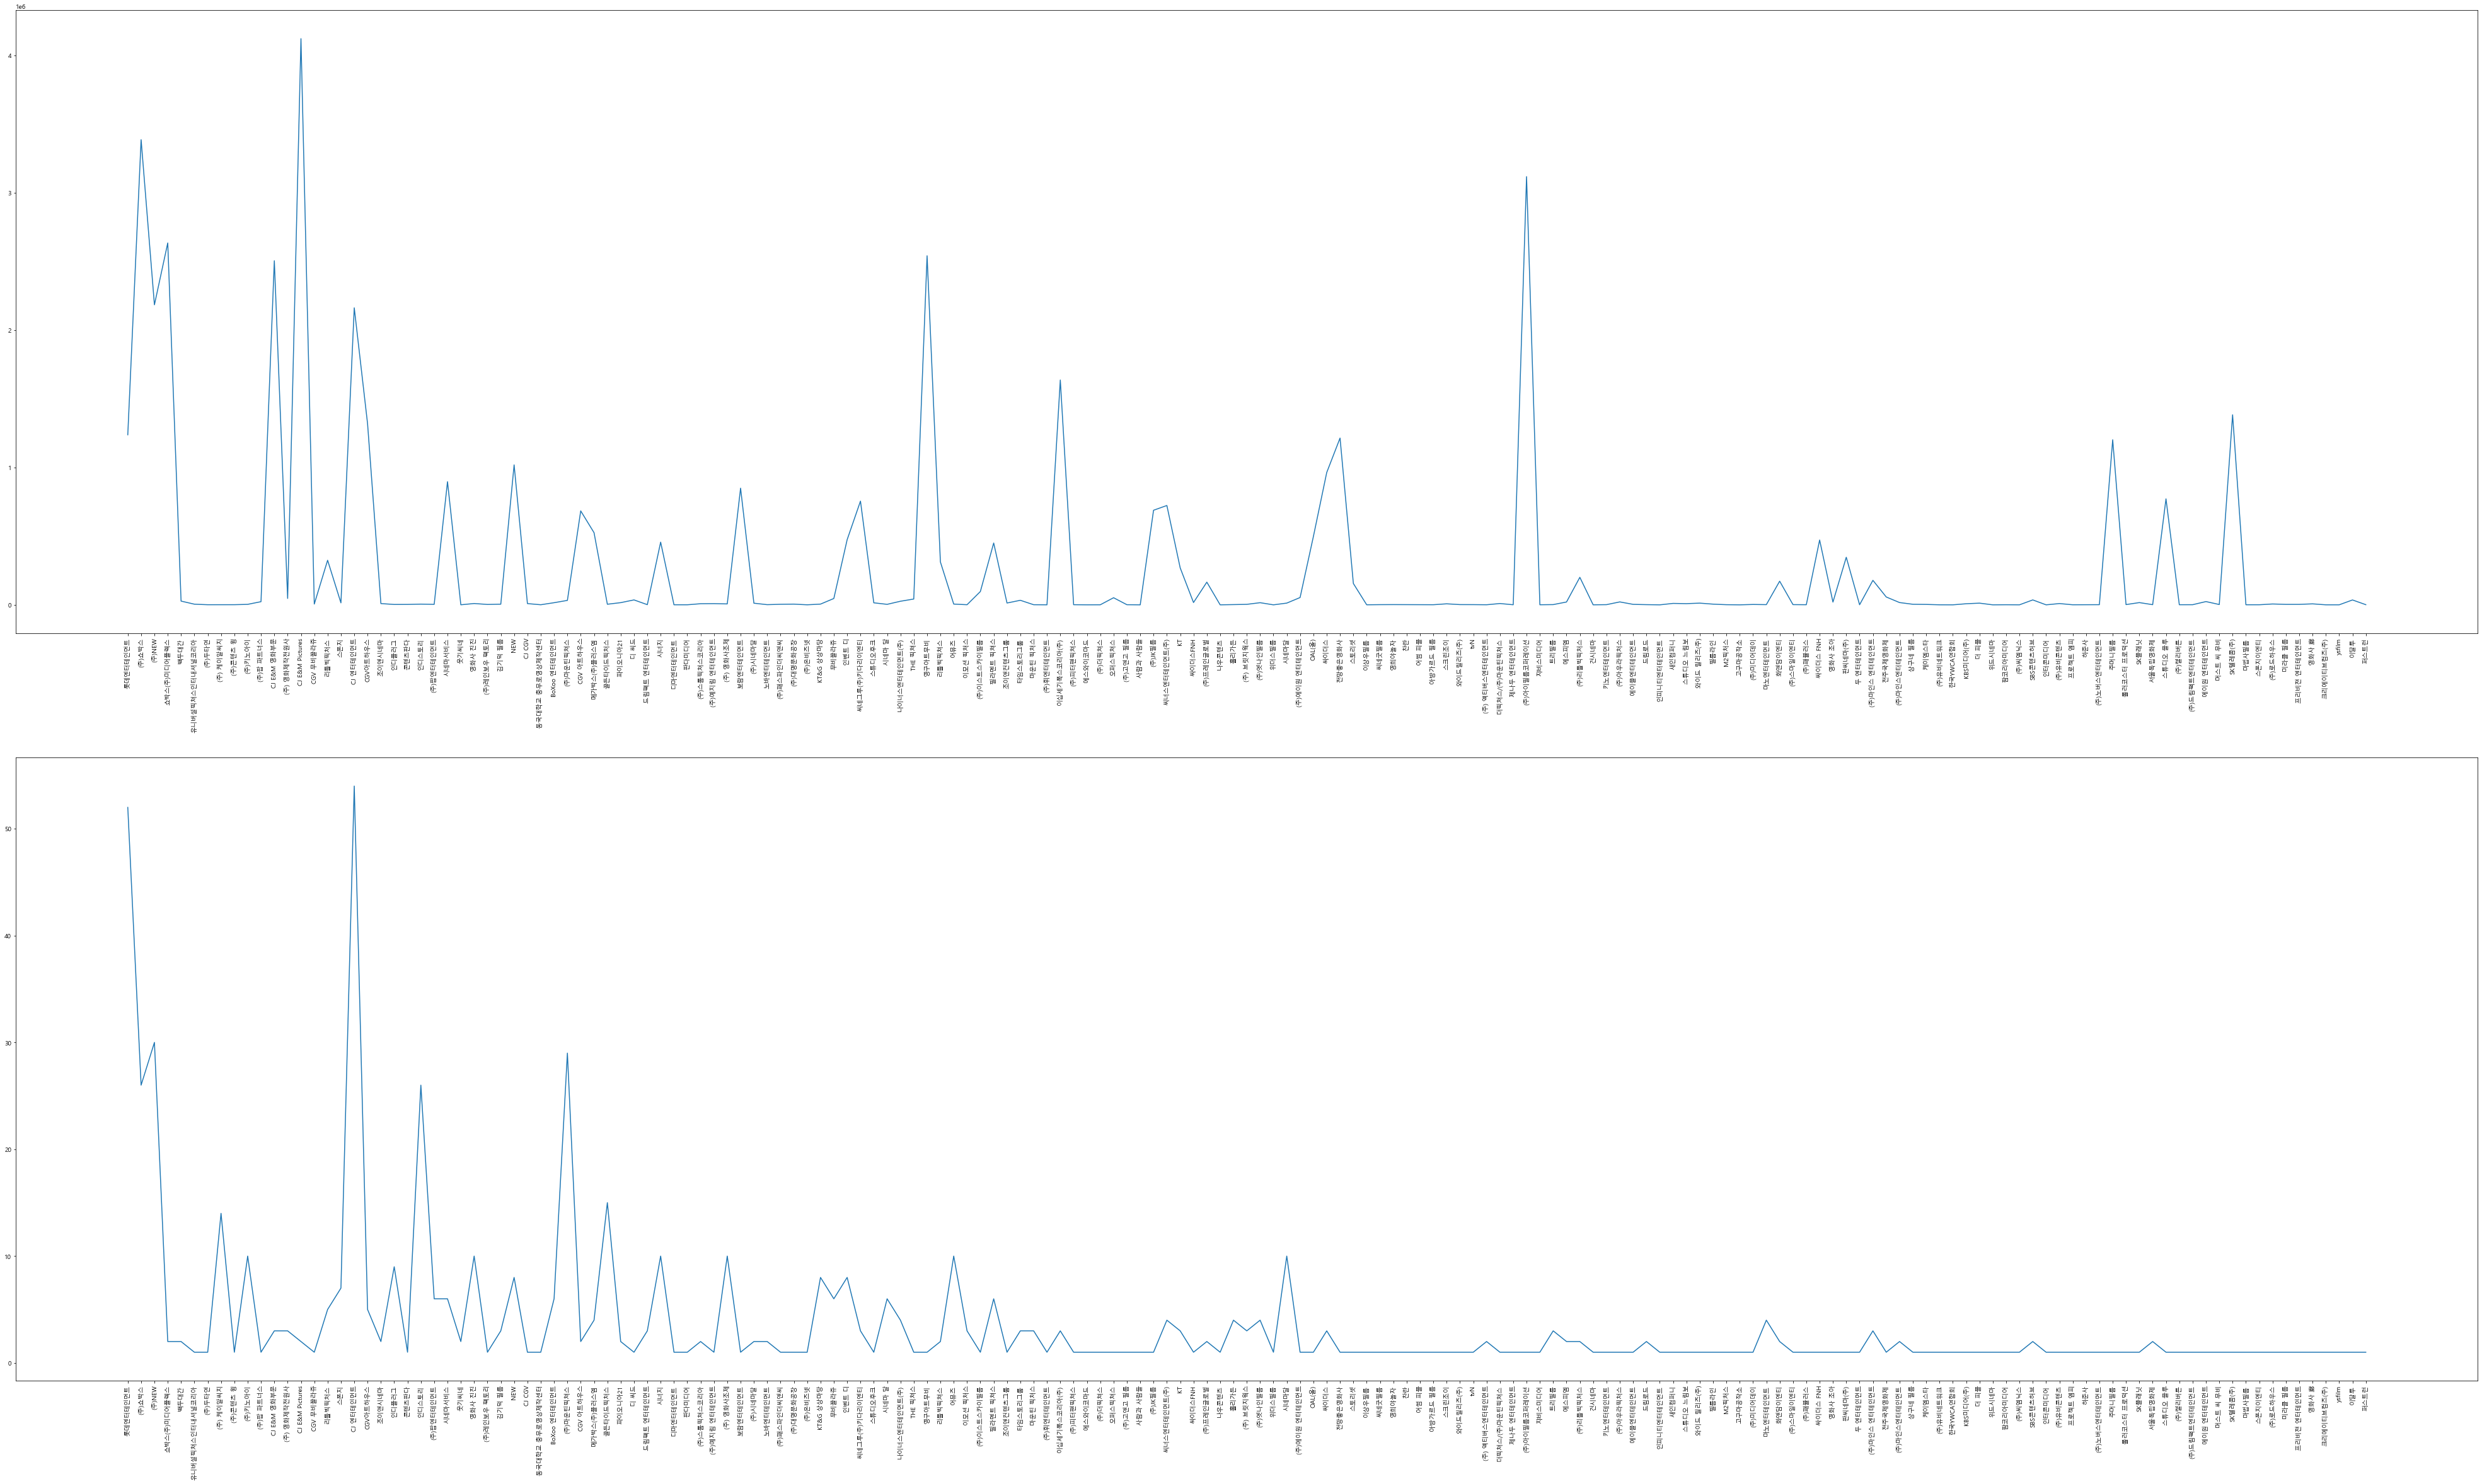

In [16]:
plt.figure(figsize=(70,40))
plt.subplot(2,1,1)
plt.plot(df_train_db_avg.index, df_train_db_avg.iloc[:,0])
plt.xticks(rotation = 90)

plt.subplot(2,1,2)
plt.plot(df_train_db_avg.index, df_train_db_avg.iloc[:,1])
plt.xticks(rotation = 90)

plt.show()
plt.close()

In [17]:
# set(df_train['distributor']) - set(df_test['distributor'])
set(df_test['distributor']) - set(df_train['distributor'])

{'(유)영화사 화수분',
 '(주)다세포클럽',
 '(주)드림웨스트픽쳐스',
 '(주)디씨드',
 '(주)루믹스미디어',
 '(주)루스이소니도스',
 '(주)씨타마운틴픽쳐스',
 '(주)영화사 빅',
 '(주)컨텐츠온미디어',
 'Cinema SAM',
 '갑종필름',
 '굿픽처스',
 '노근리 프로덕션',
 '늘푸른시네마',
 '디씨드',
 '레몬트리',
 '롯데쇼핑(주)롯데엔터테인먼트',
 '리아코어콘텐츠',
 '리얼라이즈픽쳐스',
 '마운틴픽쳐스',
 '메가박스중앙(주)플러스엠',
 '명필름',
 '모쿠슈라',
 '미디어로그',
 '미로비젼',
 '비에이치제이 시네마',
 '애니메이션 배급',
 '오픈유컬쳐',
 '와우픽쳐스',
 '유나이티드 픽처스',
 '청년필름',
 '타임스토리',
 '프리비젼',
 '필마픽쳐스',
 '핑크로봇 필름'}

In [18]:
df_train.drop(columns='distributor', inplace=True)
df_test.drop(columns='distributor', inplace=True)

#### 장르에 따라 관객 수에 영향을 줄까?

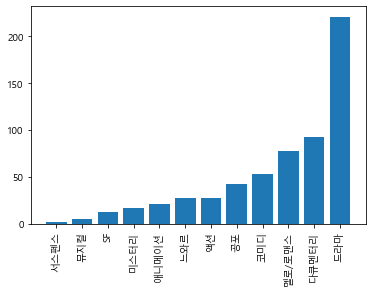

In [19]:
df_train_genre = df_train.groupby('genre').count()
plt.bar(df_train_genre['box_off_num'].sort_values().index, df_train_genre['box_off_num'].sort_values())
plt.xticks(rotation = 90)
plt.show()

In [20]:
df_train_genre['box_off_num'].sort_values()

genre
서스펜스        2
뮤지컬         5
SF         13
미스터리       17
애니메이션      21
느와르        27
액션         28
공포         42
코미디        53
멜로/로맨스     78
다큐멘터리      93
드라마       221
Name: box_off_num, dtype: int64

In [21]:
genre_name = df_train_genre['box_off_num'].sort_values().index
genre_avg = [df_train[ df_train['genre'] == i]['box_off_num'].mean()  for i in genre_name]

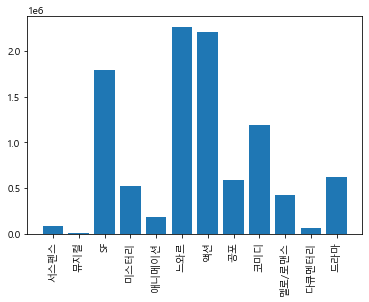

In [22]:
plt.bar(genre_name, genre_avg)
plt.xticks(rotation = 90)
plt.show()

In [23]:
df_train.info(), df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   genre          600 non-null    object
 1   release_time   600 non-null    object
 2   time           600 non-null    int64 
 3   screening_rat  600 non-null    object
 4   director       600 non-null    object
 5   dir_prev_num   600 non-null    int64 
 6   num_staff      600 non-null    int64 
 7   num_actor      600 non-null    int64 
 8   box_off_num    600 non-null    int64 
dtypes: int64(5), object(4)
memory usage: 42.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   genre          243 non-null    object
 1   release_time   243 non-null    object
 2   time           243 non-null    int64 
 3   screening_rat  243 non-null    object
 4   direc

(None, None)

In [24]:
for i in range(len(df_train)):
    for ii in range(len(genre_name)):
        if df_train['genre'][i] == genre_name[ii]:
            df_train['genre'][i] = genre_avg[ii]
 
for i in range(len(df_test)):
    for ii in range(len(genre_name)):
        if df_test['genre'][i] == genre_name[ii]:
            df_test['genre'][i] = genre_avg[ii]

C:\Users\HPE\AppData\Local\Temp/ipykernel_8024/4036087803.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['genre'][i] = genre_avg[ii]
C:\Users\HPE\AppData\Local\Temp/ipykernel_8024/4036087803.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['genre'][i] = genre_avg[ii]


In [25]:
df_train['genre'] = df_train['genre'].astype(float)
df_test['genre'] = df_test['genre'].astype(float)
# df_train.drop(columns='genre', inplace=True)
# df_test.drop(columns='genre', inplace=True)

#### director 처리를 어떻게 해야할까? 

In [26]:
len(set(df_train['director']) & set(df_test['director']) )

78

In [27]:
len(set(df_train['director']) - set(df_test['director']) )

394

In [28]:
len(set(df_test['director']) - set(df_train['director']) )

142

In [29]:
df_train.drop(columns=['director'], inplace=True)
df_test.drop(columns=['director'], inplace=True)

#### Label encoding - release_time 수정하기

In [30]:
df_train['release_time'] = [i[:-3] for i in df_train['release_time']]
df_test['release_time'] = [i[:-3] for i in df_test['release_time']]

In [31]:
df_train.sort_values(by='release_time')['release_time'].unique()

array(['2010-01', '2010-02', '2010-03', '2010-04', '2010-05', '2010-06',
       '2010-07', '2010-08', '2010-09', '2010-10', '2010-11', '2010-12',
       '2011-01', '2011-02', '2011-03', '2011-04', '2011-05', '2011-06',
       '2011-07', '2011-08', '2011-09', '2011-10', '2011-11', '2011-12',
       '2012-01', '2012-02', '2012-03', '2012-04', '2012-05', '2012-06',
       '2012-07', '2012-08', '2012-09', '2012-10', '2012-11', '2012-12',
       '2013-01', '2013-02', '2013-03', '2013-04', '2013-05', '2013-06',
       '2013-07', '2013-08', '2013-09', '2013-10', '2013-11', '2013-12',
       '2014-01', '2014-02', '2014-03', '2014-04', '2014-05', '2014-06',
       '2014-07', '2014-08', '2014-09', '2014-10', '2014-11', '2014-12',
       '2015-01', '2015-02', '2015-03', '2015-04', '2015-05', '2015-06',
       '2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12'],
      dtype=object)

In [32]:
df_test.sort_values(by='release_time')['release_time'].unique()

array(['2010-01', '2010-02', '2010-03', '2010-04', '2010-05', '2010-06',
       '2010-08', '2010-09', '2010-10', '2010-11', '2010-12', '2011-01',
       '2011-02', '2011-03', '2011-04', '2011-05', '2011-06', '2011-07',
       '2011-08', '2011-09', '2011-10', '2011-11', '2011-12', '2012-01',
       '2012-02', '2012-03', '2012-04', '2012-05', '2012-06', '2012-08',
       '2012-09', '2012-10', '2012-11', '2012-12', '2013-01', '2013-02',
       '2013-03', '2013-05', '2013-06', '2013-07', '2013-08', '2013-10',
       '2013-11', '2013-12', '2014-01', '2014-02', '2014-03', '2014-04',
       '2014-05', '2014-06', '2014-07', '2014-08', '2014-09', '2014-10',
       '2014-11', '2014-12', '2015-01', '2015-02', '2015-03', '2015-04',
       '2015-05', '2015-06', '2015-07', '2015-08', '2015-09', '2015-10',
       '2015-11', '2015-12'], dtype=object)

In [33]:
set(df_train.sort_values(by='release_time')['release_time']) - set(df_test.sort_values(by='release_time')['release_time'])

{'2010-07', '2012-07', '2013-04', '2013-09'}

In [34]:
set(df_test.sort_values(by='release_time')['release_time']) - set(df_train.sort_values(by='release_time')['release_time'])

set()

In [35]:
df_test

,genre,release_time,time,screening_rat,dir_prev_num,num_staff,num_actor
0,2.263695e+06,2010-01,125,청소년 관람불가,2,304,3
1,4.259680e+05,2010-01,113,12세 관람가,4,275,3
2,6.256898e+05,2010-01,115,12세 관람가,3,419,7
3,2.203974e+06,2010-02,116,15세 관람가,2,408,2
4,5.908325e+05,2010-02,110,15세 관람가,1,380,1
...,...,...,...,...,...,...,...
238,6.256898e+05,2015-11,78,15세 관람가,1,4,4
239,6.717226e+04,2015-10,86,12세 관람가,0,18,2
240,2.263695e+06,2015-10,107,청소년 관람불가,0,224,4
241,6.256898e+05,2015-10,102,청소년 관람불가,1,68,7


In [36]:
release_label = list(range(len(df_train.sort_values(by='release_time')['release_time'].unique())))
release_label_date = sorted(list(set(df_train.sort_values(by='release_time')['release_time'])))

for i in range(len(df_train)):
    for ii in range(len(release_label_date)):
        if df_train['release_time'][i] == release_label_date[ii]:
            df_train['release_time'][i] = ii
 
for i in range(len(df_test)):
    for ii in range(len(release_label_date)):
        if df_test['release_time'][i] == release_label_date[ii]:
            df_test['release_time'][i] = ii

C:\Users\HPE\AppData\Local\Temp/ipykernel_8024/1623625423.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['release_time'][i] = ii
C:\Users\HPE\AppData\Local\Temp/ipykernel_8024/1623625423.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['release_time'][i] = ii


In [37]:
df_train['release_time'] = df_train['release_time'].astype(int)
df_test['release_time'] = df_test['release_time'].astype(int)

#### Label encoding - screening_rat 

In [38]:
feature = ['screening_rat']

for i in feature:
    le = LabelEncoder()
    le = le.fit(df_train[i])
    df_train[i] = le.transform(df_train[i])
    df_test[i] = le.transform(df_test[i])

In [39]:
df_train

,genre,release_time,time,screening_rat,dir_prev_num,num_staff,num_actor,box_off_num
0,2.203974e+06,34,96,3,0,91,2,23398
1,2.263695e+06,70,130,3,2,387,3,7072501
2,2.203974e+06,41,123,1,4,343,4,6959083
3,1.193914e+06,30,101,2,2,20,6,217866
4,1.193914e+06,10,108,1,1,251,2,483387
...,...,...,...,...,...,...,...,...
595,6.256898e+05,55,111,3,1,510,7,1475091
596,6.256898e+05,38,127,1,1,286,6,1716438
597,5.908325e+05,8,99,3,0,123,4,2475
598,2.263695e+06,64,102,1,0,431,4,2192525


In [40]:
x, y = df_train.iloc[:, :-1], df_train.iloc[:, -1]

### 비가공 ,표준화, 정규화

In [41]:
ss = StandardScaler()
ms = MinMaxScaler()

ss = ss.fit(x)
ms = ms.fit(x)

train_x_ss = ss.transform(x)
test_x_ss = ss.transform(df_test)

train_x_ms = ms.transform(x)
test_x_ms = ms.transform(df_test)

In [42]:
train_x, test_x, train_y, test_y = train_test_split(df_train.iloc[:, :-1], df_train.iloc[:, -1],
                                                   test_size= 0.2, random_state= 200)

train_x__ss, test_x__ss, train_y__ss, test_y__ss = train_test_split(train_x_ss, y,
                                                   test_size= 0.2, random_state= 200)

train_x__ms, test_x__ms, train_y__ms, test_y__ms = train_test_split(train_x_ms, y,
                                                   test_size= 0.2, random_state= 200)

In [43]:
lr = LinearRegression()
lr.fit(train_x, train_y)
pred_y = lr.predict(test_x)

lr_ss = LinearRegression()
lr_ss.fit(train_x__ss, train_y__ss)
pred_y__ss = lr_ss.predict(test_x__ss)

lr_ms = LinearRegression()
lr_ms.fit(train_x__ms, train_y__ms)
pred_y__ms = lr_ms.predict(test_x__ms)

In [55]:
print("훈련세트 점수: {:.2f}".format( lr.score(train_x, train_y) ))
print("테스트세트 점수: {:.2f}".format( lr.score(test_x, test_y) ))
print('mse :', mean_squared_error(test_y, pred_y))
print()
print("훈련세트 점수: {:.2f}".format( lr_ss.score(train_x__ss, train_y__ss) ))
print("테스트세트 점수: {:.2f}".format( lr_ss.score(test_x__ss, test_y__ss) ))
print()
print("훈련세트 점수: {:.2f}".format( lr_ms.score(train_x__ms, train_y__ms) ))
print("테스트세트 점수: {:.2f}".format( lr_ms.score(test_x__ms, test_y__ms) ))

훈련세트 점수: 0.34
테스트세트 점수: 0.23
mse : 1868009189952.2166

훈련세트 점수: 0.34
테스트세트 점수: 0.23

훈련세트 점수: 0.34
테스트세트 점수: 0.23


In [45]:
df_train.corr(method='pearson')

,genre,release_time,time,screening_rat,dir_prev_num,num_staff,num_actor,box_off_num
genre,1.000000,-0.023807,0.349327,0.063042,0.255038,0.448027,0.040303,0.325269
release_time,-0.023807,1.000000,-0.065143,0.101975,0.135373,-0.032676,-0.099268,0.000619
time,0.349327,-0.065143,1.000000,-0.136358,0.306727,0.623205,0.114153,0.441452
screening_rat,0.063042,0.101975,-0.136358,1.000000,-0.133886,-0.181633,-0.042339,-0.169423
dir_prev_num,0.255038,0.135373,0.306727,-0.133886,1.000000,0.450706,0.014006,0.259674
num_staff,0.448027,-0.032676,0.623205,-0.181633,0.450706,1.000000,0.077871,0.544265
num_actor,0.040303,-0.099268,0.114153,-0.042339,0.014006,0.077871,1.000000,0.111179
box_off_num,0.325269,0.000619,0.441452,-0.169423,0.259674,0.544265,0.111179,1.000000


## release_time 제거 후 다시 진행

In [46]:
df_train.drop(columns='release_time', inplace=True)
df_test.drop(columns='release_time', inplace=True)

In [47]:
x, y = df_train.iloc[:, :-1], df_train.iloc[:, -1]

ss = StandardScaler()
ms = MinMaxScaler()

ss = ss.fit(x)
ms = ms.fit(x)

train_x_ss = ss.transform(x)
test_x_ss = ss.transform(df_test)

train_x_ms = ms.transform(x)
test_x_ms = ms.transform(df_test)

train_x, test_x, train_y, test_y = train_test_split(df_train.iloc[:, :-1], df_train.iloc[:, -1],
                                                   test_size= 0.2, random_state= 200)

train_x__ss, test_x__ss, train_y__ss, test_y__ss = train_test_split(train_x_ss, y,
                                                   test_size= 0.2, random_state= 200)

train_x__ms, test_x__ms, train_y__ms, test_y__ms = train_test_split(train_x_ms, y,
                                                   test_size= 0.2, random_state= 200)

lr = LinearRegression()
lr.fit(train_x, train_y)
pred_y = lr.predict(test_x)

lr_ss = LinearRegression()
lr_ss.fit(train_x__ss, train_y__ss)
pred_y__ss = lr_ss.predict(test_x__ss)

lr_ms = LinearRegression()
lr_ms.fit(train_x__ms, train_y__ms)
pred_y__ms = lr_ms.predict(test_x__ms)

print("훈련세트 점수: {:.2f}".format( lr.score(train_x, train_y) ))
print("테스트세트 점수: {:.2f}".format( lr.score(test_x, test_y) ))
print()
print("훈련세트 점수: {:.2f}".format( lr_ss.score(train_x__ss, train_y__ss) ))
print("테스트세트 점수: {:.2f}".format( lr_ss.score(test_x__ss, test_y__ss) ))
print()
print("훈련세트 점수: {:.2f}".format( lr_ms.score(train_x__ms, train_y__ms) ))
print("테스트세트 점수: {:.2f}".format( lr_ms.score(test_x__ms, test_y__ms) ))

훈련세트 점수: 0.34
테스트세트 점수: 0.24

훈련세트 점수: 0.34
테스트세트 점수: 0.24

훈련세트 점수: 0.34
테스트세트 점수: 0.24


In [48]:
df_train.corr()

,genre,time,screening_rat,dir_prev_num,num_staff,num_actor,box_off_num
genre,1.000000,0.349327,0.063042,0.255038,0.448027,0.040303,0.325269
time,0.349327,1.000000,-0.136358,0.306727,0.623205,0.114153,0.441452
screening_rat,0.063042,-0.136358,1.000000,-0.133886,-0.181633,-0.042339,-0.169423
dir_prev_num,0.255038,0.306727,-0.133886,1.000000,0.450706,0.014006,0.259674
num_staff,0.448027,0.623205,-0.181633,0.450706,1.000000,0.077871,0.544265
num_actor,0.040303,0.114153,-0.042339,0.014006,0.077871,1.000000,0.111179
box_off_num,0.325269,0.441452,-0.169423,0.259674,0.544265,0.111179,1.000000


## num_actor 제거 후 다시 진행

In [49]:
df_train.drop(columns='num_actor', inplace=True)
df_test.drop(columns='num_actor', inplace=True)

In [50]:
x, y = df_train.iloc[:, :-1], df_train.iloc[:, -1]

ss = StandardScaler()
ms = MinMaxScaler()

ss = ss.fit(x)
ms = ms.fit(x)

train_x_ss = ss.transform(x)
test_x_ss = ss.transform(df_test)

train_x_ms = ms.transform(x)
test_x_ms = ms.transform(df_test)

train_x, test_x, train_y, test_y = train_test_split(df_train.iloc[:, :-1], df_train.iloc[:, -1],
                                                   test_size= 0.2, random_state= 200)

train_x__ss, test_x__ss, train_y__ss, test_y__ss = train_test_split(train_x_ss, y,
                                                   test_size= 0.2, random_state= 200)

train_x__ms, test_x__ms, train_y__ms, test_y__ms = train_test_split(train_x_ms, y,
                                                   test_size= 0.2, random_state= 200)

lr = LinearRegression()
lr.fit(train_x, train_y)
pred_y = lr.predict(test_x)

lr_ss = LinearRegression()
lr_ss.fit(train_x__ss, train_y__ss)
pred_y__ss = lr_ss.predict(test_x__ss)

lr_ms = LinearRegression()
lr_ms.fit(train_x__ms, train_y__ms)
pred_y__ms = lr_ms.predict(test_x__ms)

print("훈련세트 점수: {:.2f}".format( lr.score(train_x, train_y) ))
print("테스트세트 점수: {:.2f}".format( lr.score(test_x, test_y) ))
print()
print("훈련세트 점수: {:.2f}".format( lr_ss.score(train_x__ss, train_y__ss) ))
print("테스트세트 점수: {:.2f}".format( lr_ss.score(test_x__ss, test_y__ss) ))
print()
print("훈련세트 점수: {:.2f}".format( lr_ms.score(train_x__ms, train_y__ms) ))
print("테스트세트 점수: {:.2f}".format( lr_ms.score(test_x__ms, test_y__ms) ))

훈련세트 점수: 0.34
테스트세트 점수: 0.23

훈련세트 점수: 0.34
테스트세트 점수: 0.23

훈련세트 점수: 0.34
테스트세트 점수: 0.23


movies_train.csv / movies_test.csv title : 영화의 제목 distributor : 배급사 genre : 장르 release_time : 개봉일 time : 상영시간(분) screening_rat : 상영등급 director : 감독이름 dir_prev_bfnum : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화에서의 평균 관객수(단 관객수가 알려지지 않은 영화 제외) dir_prev_num : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화의 개수(단 관객수가 알려지지 않은 영화 제외) num_staff : 스텝수 num_actor : 주연배우수 box_off_num : 관객수

In [51]:
df_train.corr()

,genre,time,screening_rat,dir_prev_num,num_staff,box_off_num
genre,1.000000,0.349327,0.063042,0.255038,0.448027,0.325269
time,0.349327,1.000000,-0.136358,0.306727,0.623205,0.441452
screening_rat,0.063042,-0.136358,1.000000,-0.133886,-0.181633,-0.169423
dir_prev_num,0.255038,0.306727,-0.133886,1.000000,0.450706,0.259674
num_staff,0.448027,0.623205,-0.181633,0.450706,1.000000,0.544265
box_off_num,0.325269,0.441452,-0.169423,0.259674,0.544265,1.000000
